In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
#import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')  


In [3]:
base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
print(base_skin_dir)


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

C:/Users/Annu/Desktop/Sem 4


In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<AxesSubplot:>

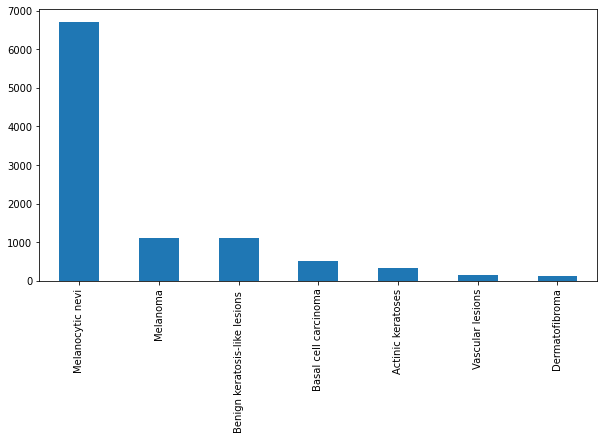

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

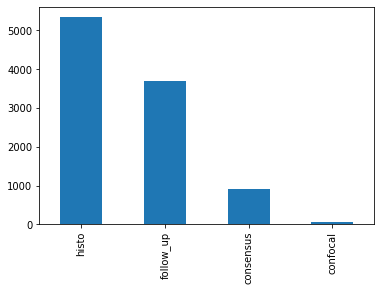

In [10]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

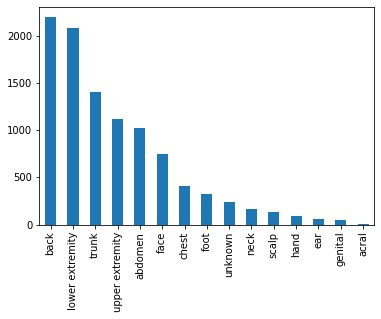

In [11]:
skin_df['localization'].value_counts().plot(kind='bar')

<AxesSubplot:>

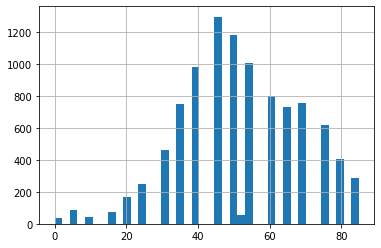

In [12]:
skin_df['age'].hist(bins=40)

<AxesSubplot:>

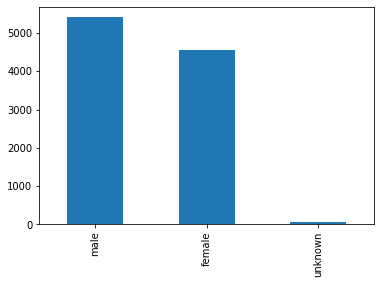

In [13]:
skin_df['sex'].value_counts().plot(kind='bar')

In [14]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2


In [15]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [16]:

from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

np.random.seed(123)

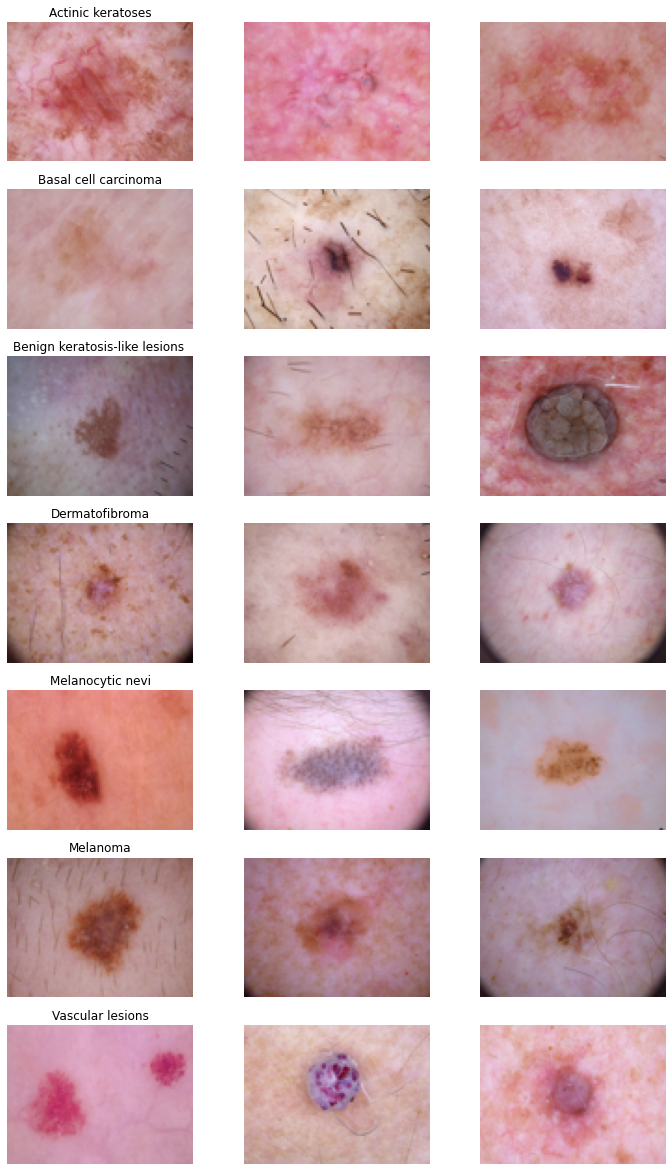

In [18]:
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(m_axs,skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [21]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}
#Read File csv
skin_df = pd.read_csv('HAM10000_metadata.csv')
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [22]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 10072,
Number of Rows with Null Entries: 10015 100.0%


In [23]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,path,object,10015,0
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


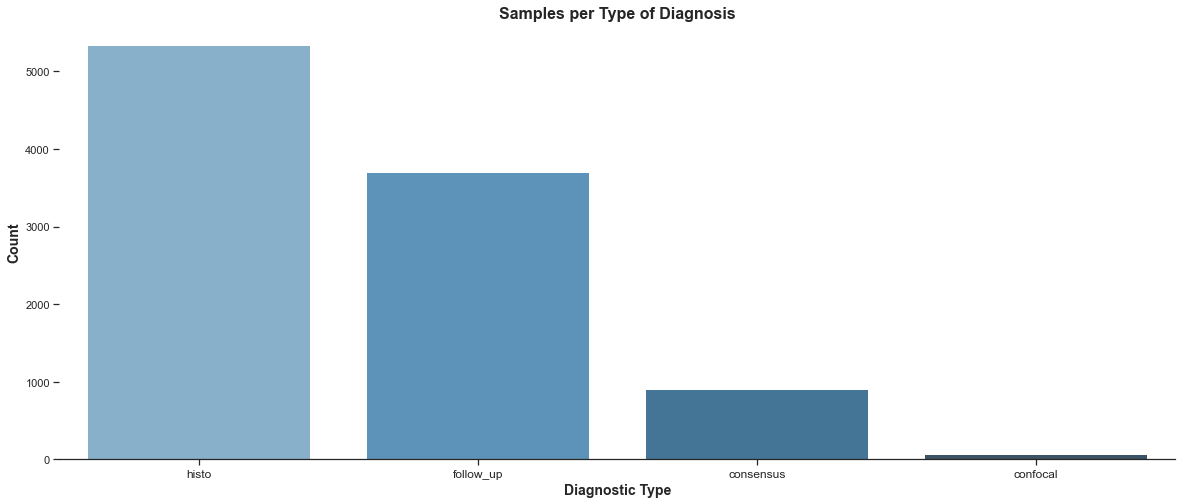

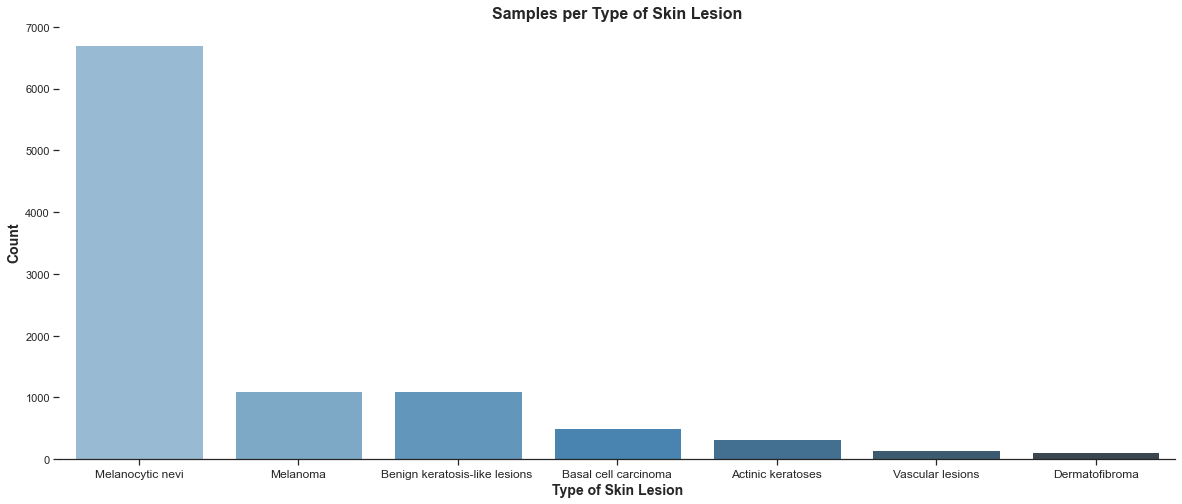

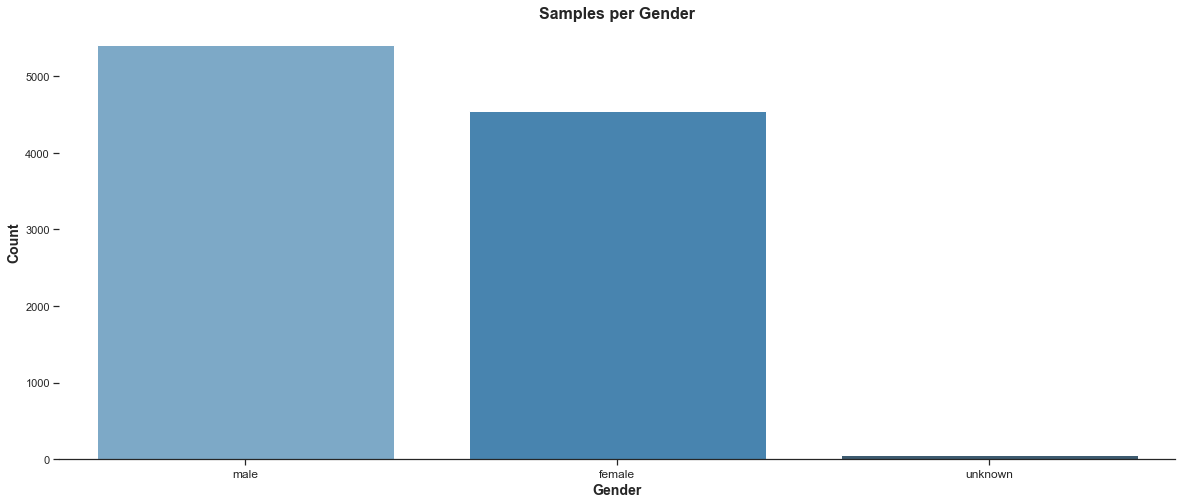

In [24]:
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Samples per Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Samples per Type of Skin Lesion')
countplot(skin_df,'sex', 'Gender', 'Count', 'Samples per Gender')

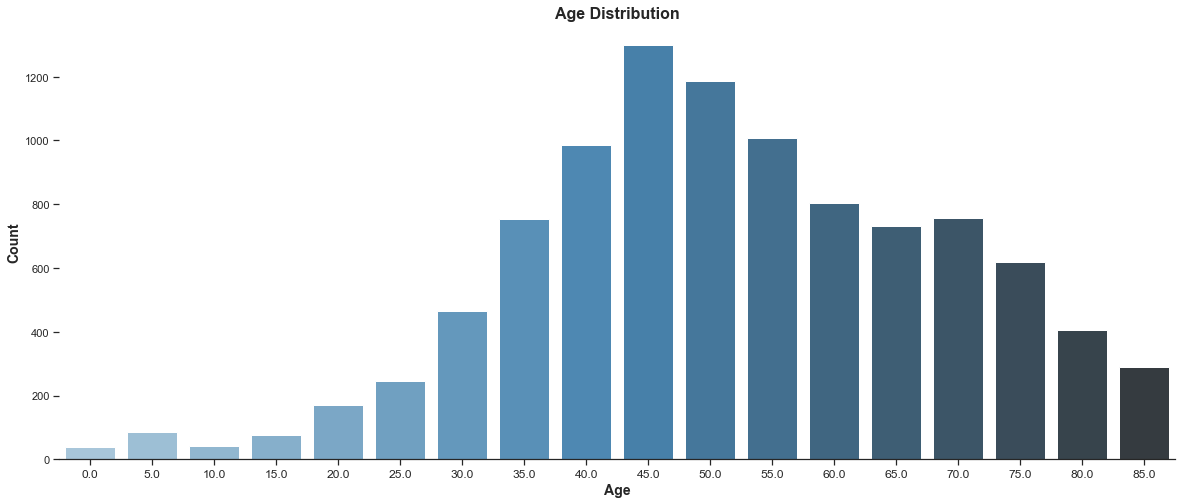

In [25]:
skin_df['age'].fillna((skin_df['age'].mode()), inplace=True)

plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_df,x='age',palette="Blues_d")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution', fontsize = 16,weight = 'bold');


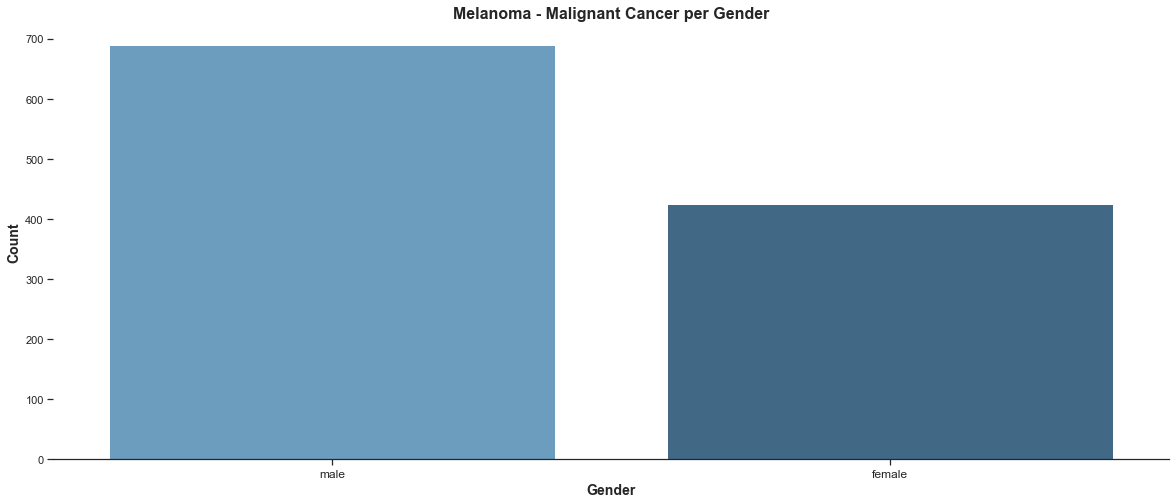

In [26]:
skin_mel = skin_df.loc[:,['age','sex','localization','cell_type']]
skin_mel = skin_mel[skin_mel['cell_type'] == 'Melanoma']

countplot(skin_mel,'sex', 'Gender', 'Count', 'Melanoma - Malignant Cancer per Gender')

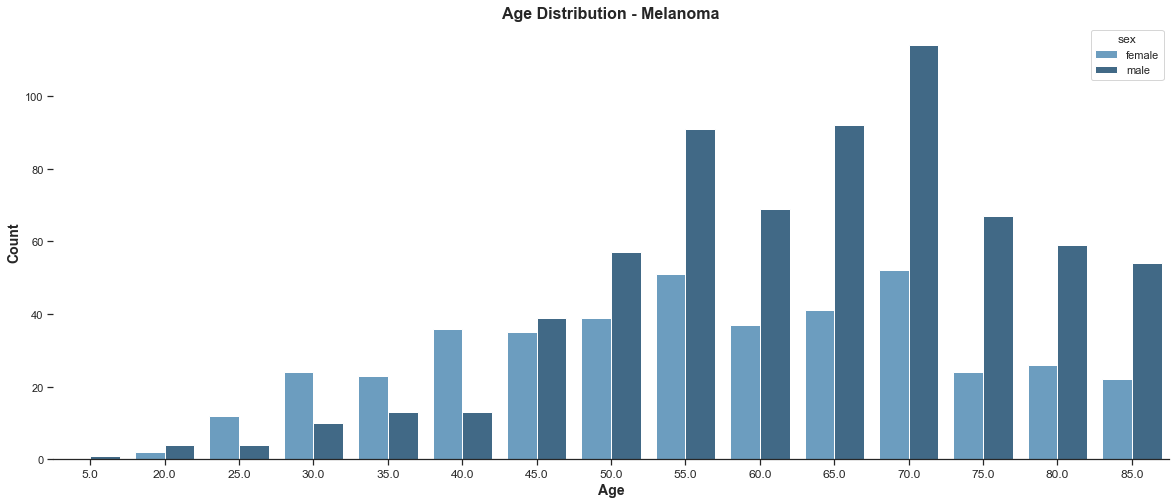

In [27]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_mel,x='age',palette="Blues_d", hue = 'sex')
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution - Melanoma', fontsize = 16,weight = 'bold');

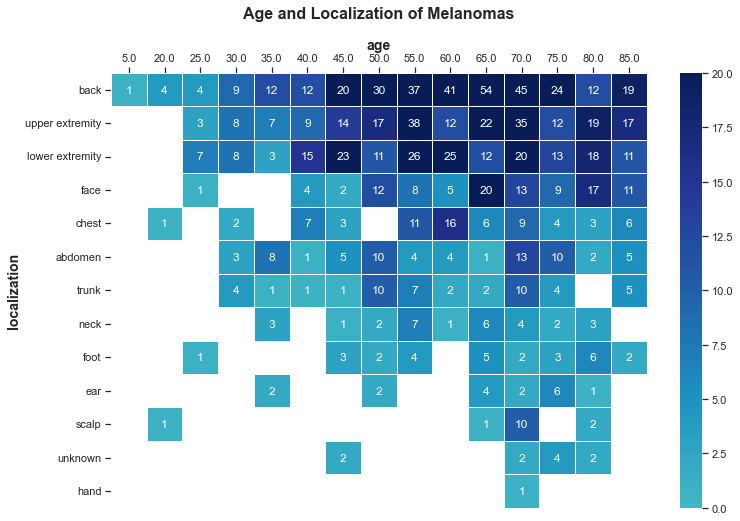

In [28]:

skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')    
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of Melanomas')

In [37]:
base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
print(base_skin_dir)


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

C:/Users/Annu/Desktop/Sem 4


In [38]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [39]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [40]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [41]:

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))


In [43]:

input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100
batch_size = 20

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=90,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,  
        shear_range = 10) 

dataaugment.fit(x_train)

def history(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    return (predictions,accuracy_t,accuracy_v,accuracy)

In [44]:
training_shape = (75,100, 3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

XCeptionmodel = base_model.output
XCeptionmodel = Flatten()(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionmodel = Dense(128, activation='relu')(XCeptionmodel)
XCeptionmodel = Dropout(0.2)(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionoutput = Dense(num_classes, activation = 'softmax')(XCeptionmodel)
XCeptionmodel = Model(inputs=base_model.input, outputs=XCeptionoutput)

for layer in base_model.layers:
    layer.trainable = True

XCeptiony_pred,XCeptionaccuracy_t,XCeptionaccuracy_v,XCeptionaccuracy = history(XCeptionmodel)
    
print("XCeption Training: accuracy = %f" % (XCeptionaccuracy_t))
print("XCeption Validation: accuracy = %f" % (XCeptionaccuracy_v))
print("XCeption Test: accuracy = %f" % (XCeptionaccuracy))


XCeption Training: accuracy = 0.949376
XCeption Validation: accuracy = 0.841646
XCeption Test: accuracy = 0.825761
